# CA03 - Decision Tree Algorithm

## 1. Data Source and Contents

In [46]:
# Install necessary packages

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
 
from IPython.display import Image  
import graphviz
from sklearn.tree import export_graphviz
import pydotplus
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_roc_curve

from tabulate import tabulate

!pip install six
from six import StringIO

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Q.1 Why does it make sense to discretize columns for this problem?


> It makes sense to discretize the columns for this problem because otherwise we would have had to use a regressor decisision tree. This would not allow us to categorize the target classes, but instead estimate the income of the individual.



Q.2 What might be the issues (if any) if we DID NOT discretize the columns?


> As mentioned above, if we did not discretize the columns then some of them would be continuous variables and so we would have to use a regressor decision tree.



In [3]:
# Read in data
df = pd.read_csv("https://github.com/ArinB/MSBA-CA-03-Decision-Trees/blob/master/census_data.csv?raw=true")

In [5]:
# Look at first few rows of the data
df.head()

,hours_per_week_bin,occupation_bin,msr_bin,capital_gl_bin,race_sex_bin,education_num_bin,education_bin,workclass_bin,age_bin,flag,y
0,b. 31-40,b. Mid - Low,b. Mid,c. > 0,c. High,c. 13,c. Bachelors,b. income,d. 36-40 & 56-60,train,0
1,a. 0-30,e. High,c. High,a. = 0,c. High,c. 13,c. Bachelors,b. income,e. 40-55,train,0
2,b. 31-40,a. Low,b. Mid,a. = 0,c. High,b. 9-12,b. Mid,b. income,d. 36-40 & 56-60,train,0
3,b. 31-40,a. Low,c. High,a. = 0,b. Mid,a. 0-8,a. Low,b. income,e. 40-55,train,0
4,b. 31-40,e. High,c. High,a. = 0,a. Low,c. 13,c. Bachelors,b. income,b. 26-30 & 71-100,train,0


In [6]:
# Look at basic information on the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   hours_per_week_bin  48842 non-null  object
 1   occupation_bin      48842 non-null  object
 2   msr_bin             48842 non-null  object
 3   capital_gl_bin      48842 non-null  object
 4   race_sex_bin        48842 non-null  object
 5   education_num_bin   48842 non-null  object
 6   education_bin       48842 non-null  object
 7   workclass_bin       48842 non-null  object
 8   age_bin             48842 non-null  object
 9   flag                48842 non-null  object
 10  y                   48842 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 4.1+ MB


As stated in the instructions, all of the continuous variables have been "transformed" into certain "data groups" or "data blocks" so it makes sense that the only numeric variable is y (0 or 1) while the rest are objects.

In [7]:
# Shape of the dataframe
df.shape

(48842, 11)

## 2. Data Quality Analysis (DQA)

In [8]:
# See if there are any missing values in the data
df.isnull().sum()

hours_per_week_bin    0
occupation_bin        0
msr_bin               0
capital_gl_bin        0
race_sex_bin          0
education_num_bin     0
education_bin         0
workclass_bin         0
age_bin               0
flag                  0
y                     0
dtype: int64

There are no missing values in the data, so we do not have to get rid of any rows or columns due to missing data.

In [9]:
# Descripitive Statistics for each of the columns
df.describe(include = "all")

,hours_per_week_bin,occupation_bin,msr_bin,capital_gl_bin,race_sex_bin,education_num_bin,education_bin,workclass_bin,age_bin,flag,y
count,48842,48842,48842,48842,48842,48842,48842,48842,48842,48842,48842.000000
unique,5,5,3,3,3,5,5,2,5,2,NaN
top,b. 31-40,c. Mid - Mid,c. High,a. = 0,c. High,b. 9-12,b. Mid,b. income,e. 40-55,train,NaN
freq,26639,13971,22047,42525,29737,30324,30324,46012,13963,32561,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.239282
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.426649
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000


As mentioned earlier, the data is non-numeric except for the y variable, so the descriptive statistics will not be very useful.

Since the data is binned, we cannot really see which records have outliers. Each data point is placed into a bin, so we are unable to tell which data points are far from the other points.

Individual Plots

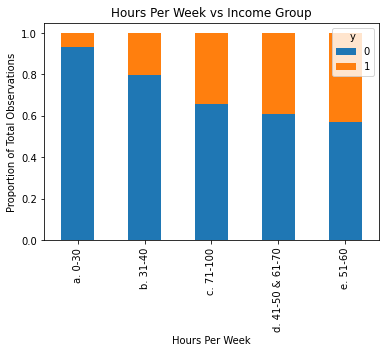

In [10]:
# For the y variable, 0 represents a salary of <=50k while a 1 represents >50k
pd.crosstab(df.hours_per_week_bin,df.y,normalize = "index").plot(kind = "bar", stacked = True)
plt.title("Hours Per Week vs Income Group")
plt.xlabel("Hours Per Week")
plt.ylabel("Proportion of Total Observations")
plt.show()

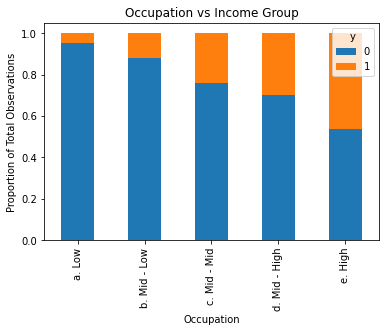

In [11]:
pd.crosstab(df.occupation_bin,df.y,normalize = "index").plot(kind = "bar", stacked = True)
plt.title("Occupation vs Income Group")
plt.xlabel("Occupation")
plt.ylabel("Proportion of Total Observations")
plt.show()

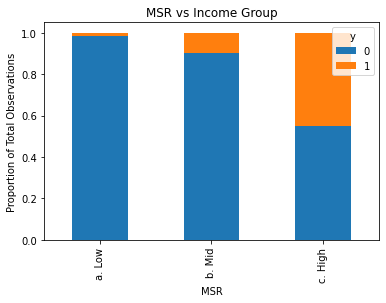

In [12]:
pd.crosstab(df.msr_bin,df.y,normalize = "index").plot(kind = "bar", stacked = True)
plt.title("MSR vs Income Group")
plt.xlabel("MSR")
plt.ylabel("Proportion of Total Observations")
plt.show()

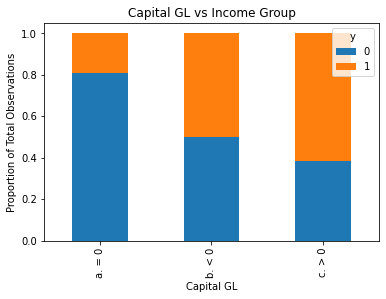

In [13]:
pd.crosstab(df.capital_gl_bin,df.y,normalize = "index").plot(kind = "bar", stacked = True)
plt.title("Capital GL vs Income Group")
plt.xlabel("Capital GL")
plt.ylabel("Proportion of Total Observations")
plt.show()

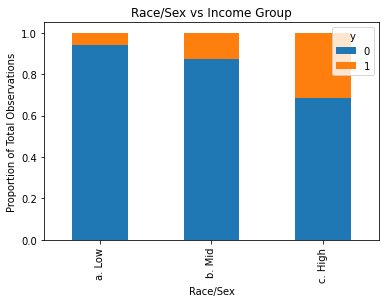

In [14]:
pd.crosstab(df.race_sex_bin,df.y,normalize = "index").plot(kind = "bar", stacked = True)
plt.title("Race/Sex vs Income Group")
plt.xlabel("Race/Sex")
plt.ylabel("Proportion of Total Observations")
plt.show()

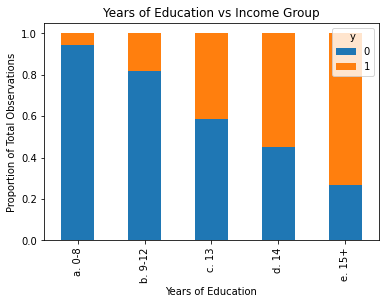

In [15]:
pd.crosstab(df.education_num_bin,df.y,normalize = "index").plot(kind = "bar", stacked = True)
plt.title("Years of Education vs Income Group")
plt.xlabel("Years of Education")
plt.ylabel("Proportion of Total Observations")
plt.show()

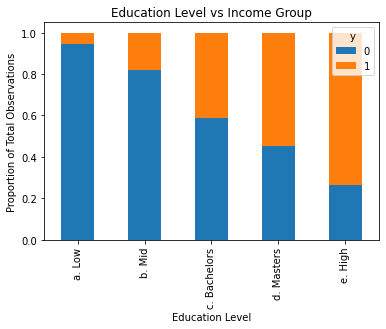

In [16]:
pd.crosstab(df.education_bin,df.y,normalize = "index").plot(kind = "bar", stacked = True)
plt.title("Education Level vs Income Group")
plt.xlabel("Education Level")
plt.ylabel("Proportion of Total Observations")
plt.show()

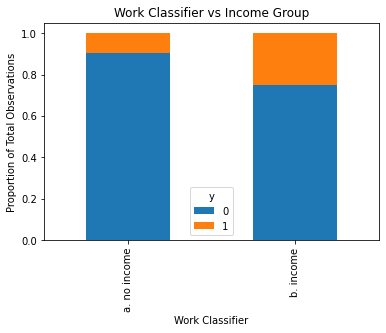

In [17]:
pd.crosstab(df.workclass_bin,df.y,normalize = "index").plot(kind = "bar", stacked = True)
plt.title("Work Classifier vs Income Group")
plt.xlabel("Work Classifier")
plt.ylabel("Proportion of Total Observations")
plt.show()

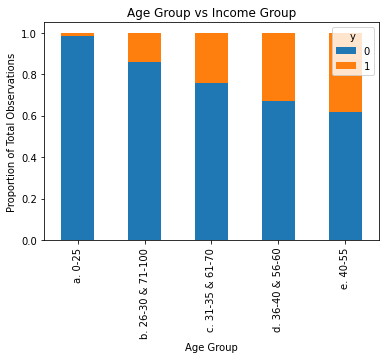

In [18]:
pd.crosstab(df.age_bin,df.y,normalize = "index").plot(kind = "bar", stacked = True)
plt.title("Age Group vs Income Group")
plt.xlabel("Age Group")
plt.ylabel("Proportion of Total Observations")
plt.show()

Comparison Plot

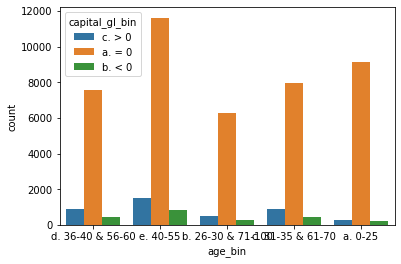

In [19]:
sns.countplot(x='age_bin', hue='capital_gl_bin', data=df)
plt.show()

In [20]:
#Encode Variables
df2 = pd.get_dummies(df, columns=["hours_per_week_bin","occupation_bin","msr_bin",
                                  "capital_gl_bin", "race_sex_bin","education_num_bin",
                                  "education_bin", "workclass_bin"	,"age_bin"], 
                          prefix=["hours_per_week_bin","occupation_bin","msr_bin",
                                  "capital_gl_bin", "race_sex_bin","education_num_bin",
                                  "education_bin", "workclass_bin"	,"age_bin"])
df2.head()

,flag,y,hours_per_week_bin_a. 0-30,hours_per_week_bin_b. 31-40,hours_per_week_bin_c. 71-100,hours_per_week_bin_d. 41-50 & 61-70,hours_per_week_bin_e. 51-60,occupation_bin_a. Low,occupation_bin_b. Mid - Low,occupation_bin_c. Mid - Mid,...,education_bin_c. Bachelors,education_bin_d. Masters,education_bin_e. High,workclass_bin_a. no income,workclass_bin_b. income,age_bin_a. 0-25,age_bin_b. 26-30 & 71-100,age_bin_c. 31-35 & 61-70,age_bin_d. 36-40 & 56-60,age_bin_e. 40-55
0,train,0,0,1,0,0,0,0,1,0,...,1,0,0,0,1,0,0,0,1,0
1,train,0,1,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,1
2,train,0,0,1,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
3,train,0,0,1,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1
4,train,0,0,1,0,0,0,0,0,0,...,1,0,0,0,1,0,1,0,0,0


# 3. Build Decision Tree Classifier Models

First, we need to split the data into training and testing data. The column labeled "flag" has already done this for us.

In [21]:
# Splitting data into Training and Testing
train_data = df2[df2.flag == "train"]
test_data = df2[df2.flag == "test"]

In [22]:
# Checking the training data
train_data.head()

,flag,y,hours_per_week_bin_a. 0-30,hours_per_week_bin_b. 31-40,hours_per_week_bin_c. 71-100,hours_per_week_bin_d. 41-50 & 61-70,hours_per_week_bin_e. 51-60,occupation_bin_a. Low,occupation_bin_b. Mid - Low,occupation_bin_c. Mid - Mid,...,education_bin_c. Bachelors,education_bin_d. Masters,education_bin_e. High,workclass_bin_a. no income,workclass_bin_b. income,age_bin_a. 0-25,age_bin_b. 26-30 & 71-100,age_bin_c. 31-35 & 61-70,age_bin_d. 36-40 & 56-60,age_bin_e. 40-55
0,train,0,0,1,0,0,0,0,1,0,...,1,0,0,0,1,0,0,0,1,0
1,train,0,1,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,1
2,train,0,0,1,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
3,train,0,0,1,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1
4,train,0,0,1,0,0,0,0,0,0,...,1,0,0,0,1,0,1,0,0,0


In [23]:
# Checking the testing data
test_data.head()

,flag,y,hours_per_week_bin_a. 0-30,hours_per_week_bin_b. 31-40,hours_per_week_bin_c. 71-100,hours_per_week_bin_d. 41-50 & 61-70,hours_per_week_bin_e. 51-60,occupation_bin_a. Low,occupation_bin_b. Mid - Low,occupation_bin_c. Mid - Mid,...,education_bin_c. Bachelors,education_bin_d. Masters,education_bin_e. High,workclass_bin_a. no income,workclass_bin_b. income,age_bin_a. 0-25,age_bin_b. 26-30 & 71-100,age_bin_c. 31-35 & 61-70,age_bin_d. 36-40 & 56-60,age_bin_e. 40-55
32561,test,0,0,1,0,0,0,0,1,0,...,0,0,0,0,1,1,0,0,0,0
32562,test,0,0,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
32563,test,1,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
32564,test,1,0,1,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
32565,test,0,1,0,0,0,0,0,1,0,...,0,0,0,1,0,1,0,0,0,0


In [24]:
# Split testing and training data with independant and dependant variables
x_train = train_data.iloc[:,2:]
y_train = train_data["y"]

x_test = test_data.iloc[:,2:]
y_test = test_data["y"]

In [26]:
# Create the Decision Tree
dtree = DecisionTreeClassifier(max_depth = 7, random_state = 101,
                               max_features = None, min_samples_leaf= 10)

In [27]:
# Testing the data with the created tree
dtree.fit(x_train,y_train)
y_pred = dtree.predict(x_test)

## Evaluate Decision Tree Performance

In [28]:
# Confusion Matrix
data_cm = confusion_matrix(y_test, y_pred)
print(data_cm)

[[11457   978]
 [ 1586  2260]]


In [29]:
# Accuracy Score
print(accuracy_score(y_test,y_pred))

0.8425158159818193


In [30]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90     12435
           1       0.70      0.59      0.64      3846

    accuracy                           0.84     16281
   macro avg       0.79      0.75      0.77     16281
weighted avg       0.84      0.84      0.84     16281



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


0.7544872651359613


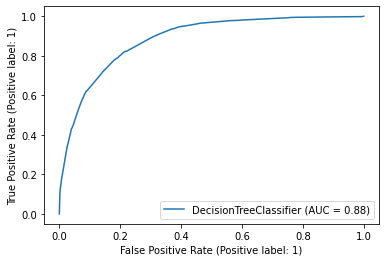

In [31]:
#print roc score 
test_auc = roc_auc_score(y_test, y_pred)
#ROC AUC Curve
plot_roc_curve(dtree, x_test, y_test)

print(test_auc)

## 5. Tune Decision Tree Performance

This section is Q.3

In [32]:
# Split Criteria (Entropy or Gini)
results_split = []
recall = []
precision = []
f1 = []
split_options = ["entropy","gini"]
for trees in split_options:
  model = DecisionTreeClassifier(criterion= trees, random_state = 101)
  model.fit(x_train,y_train)
  y_pred = model.predict(x_test)
  accuracy = np.mean(y_test==y_pred)
  results_split.append(accuracy)
  recall.append(recall_score(y_test,y_pred))
  precision.append(precision_score(y_test,y_pred))
  f1.append(f1_score(y_test,y_pred))

table = pd.DataFrame({"Split Criteria":split_options,
                      "Accuracy":results_split,
                      "Recall":recall,
                      "Precision":precision,
                      "F1 Score": f1})
table

,Split Criteria,Accuracy,Recall,Precision,F1 Score
0,entropy,0.835575,0.555382,0.688366,0.614765
1,gini,0.836435,0.553822,0.692233,0.615340


In [33]:
# Minimum Sample Leaf
results_min_leaf = []
recall = []
precision = []
f1 = []
min_leaf_options = [5,10,15,20,25,30,35,40]
for trees in min_leaf_options:
  model = DecisionTreeClassifier(min_samples_leaf= trees, random_state = 101)
  model.fit(x_train,y_train)
  y_pred = model.predict(x_test)
  accuracy = np.mean(y_test==y_pred)
  results_min_leaf.append(accuracy)
  recall.append(recall_score(y_test,y_pred))
  precision.append(precision_score(y_test,y_pred))
  f1.append(f1_score(y_test,y_pred))

table2 = pd.DataFrame({"Minimum Sample Leaf":min_leaf_options,
                      "Accuracy":results_min_leaf,
                      "Recall":recall,
                      "Precision":precision,
                      "F1 Score": f1})
table2


,Minimum Sample Leaf,Accuracy,Recall,Precision,F1 Score
0,5,0.838831,0.557462,0.699282,0.620370
1,10,0.839998,0.561102,0.701789,0.623609
2,15,0.841963,0.560322,0.709582,0.626180
3,20,0.844051,0.565523,0.714755,0.631441
4,25,0.843314,0.566303,0.711532,0.630665
5,30,0.842332,0.557202,0.712670,0.625420
6,35,0.843069,0.559802,0.714096,0.627605
7,40,0.842454,0.556942,0.713287,0.625493


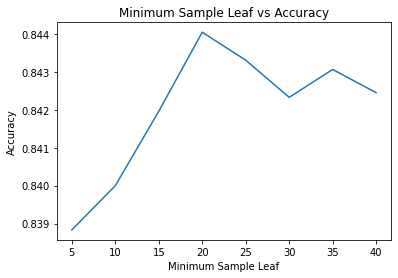

In [34]:
#Plot to see which level is best
plt.plot(min_leaf_options,results_min_leaf)
plt.title("Minimum Sample Leaf vs Accuracy")
plt.xlabel("Minimum Sample Leaf")
plt.ylabel("Accuracy")
plt.show()

In [35]:
# Maximum Feature
results_max_feat = []
recall = []
precision = []
f1 = []
max_feat_options = ["auto",None,0.3,0.4,0.5,0.6,0.7,0.8]
for trees in max_feat_options:
  model = DecisionTreeClassifier(max_features=trees, random_state = 101)
  model.fit(x_train,y_train)
  y_pred = model.predict(x_test)
  accuracy = np.mean(y_test==y_pred)
  results_max_feat.append(accuracy)
  recall.append(recall_score(y_test,y_pred))
  precision.append(precision_score(y_test,y_pred))
  f1.append(f1_score(y_test,y_pred))

table3 = pd.DataFrame({"Maximum Feature":max_feat_options,
                      "Accuracy":results_max_feat,
                      "Recall":recall,
                      "Precision":precision,
                      "F1 Score": f1})
table3

,Maximum Feature,Accuracy,Recall,Precision,F1 Score
0,auto,0.834961,0.553562,0.686996,0.613103
1,None,0.836435,0.553822,0.692233,0.615340
2,0.3,0.836681,0.557202,0.691513,0.617135
3,0.4,0.835637,0.552002,0.690182,0.613407
4,0.5,0.836128,0.554342,0.690862,0.615118
5,0.6,0.836189,0.556422,0.690100,0.616093
6,0.7,0.836988,0.556422,0.693005,0.617248
7,0.8,0.836804,0.557722,0.691712,0.617533


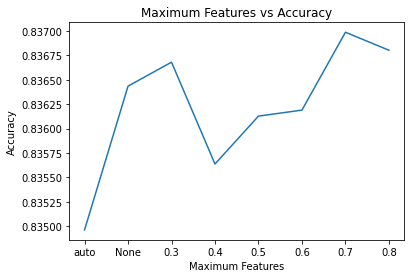

In [36]:
plt.plot(["auto","None",0.3,0.4,0.5,0.6,0.7,0.8],results_max_feat)
plt.title("Maximum Features vs Accuracy")
plt.xlabel("Maximum Features")
plt.ylabel("Accuracy")
plt.show()

In [37]:
# Maximum Depth
results_max_dep = []
recall = []
precision = []
f1 = []
max_depth_options = [2,4,6,8,10,12,14,16,18,20]
for trees in max_depth_options:
  model = DecisionTreeClassifier(max_depth = trees, random_state = 101)
  model.fit(x_train,y_train)
  y_pred = model.predict(x_test)
  accuracy = np.mean(y_test==y_pred)
  results_max_dep.append(accuracy)
  recall.append(recall_score(y_test,y_pred))
  precision.append(precision_score(y_test,y_pred))
  f1.append(f1_score(y_test,y_pred))

table4 = pd.DataFrame({"Maximum Depth":max_depth_options,
                      "Accuracy":results_max_dep,
                      "Recall":recall,
                      "Precision":precision,
                      "F1 Score": f1})
table4

,Maximum Depth,Accuracy,Recall,Precision,F1 Score
0,2,0.816596,0.397816,0.695455,0.506120
1,4,0.827590,0.463859,0.705417,0.559686
2,6,0.839875,0.583983,0.690440,0.632765
3,8,0.841840,0.551742,0.713757,0.622379
4,10,0.841226,0.573063,0.700350,0.630345
5,12,0.838646,0.575403,0.690053,0.627534
6,14,0.838585,0.569683,0.692478,0.625107
7,16,0.836619,0.555902,0.691909,0.616494
8,18,0.836374,0.554342,0.691759,0.615473
9,20,0.836497,0.553822,0.692458,0.615429


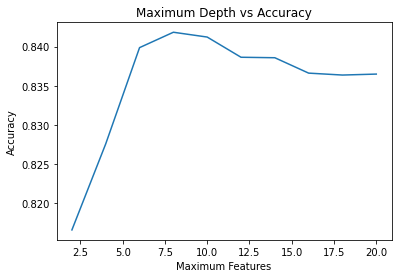

In [39]:
# Plot to see which level is best
plt.plot(max_depth_options,results_max_dep)
plt.title("Maximum Depth vs Accuracy")
plt.xlabel("Maximum Features")
plt.ylabel("Accuracy")
plt.show()

## 6. Visualize Your Best Decision Tree Using GraphViz

The best hyper-parameter values were as follows:


1.   Split Criteria: Gini Index
2.   Minimum Sample Leaf: 20
3.   Maximum Feature: 0.7 
4.   Maximum Depth: 8



In [40]:
# Create tree with hyper-parameters above:
dtree = DecisionTreeClassifier(max_depth = 8, random_state = 101,
                               max_features = 0.7, min_samples_leaf= 20, criterion = 'gini')
dtree.fit(x_train,y_train)
y_pred = dtree.predict(x_test)

In [41]:
# Confusion Matrix
data_cm = confusion_matrix(y_test, y_pred)
print(data_cm)

[[11538   897]
 [ 1646  2200]]


In [42]:
# Accuracy Score
print(accuracy_score(y_test,y_pred))

0.8438056630428107


In [43]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90     12435
           1       0.71      0.57      0.63      3846

    accuracy                           0.84     16281
   macro avg       0.79      0.75      0.77     16281
weighted avg       0.84      0.84      0.84     16281



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


0.749943889191032


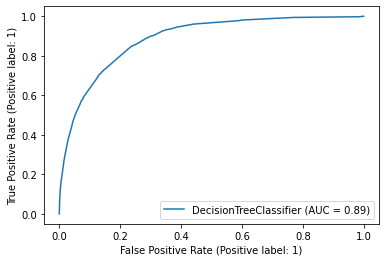

In [44]:
#print roc score 
test_auc = roc_auc_score(y_test, y_pred)
#ROC AUC Curve
plot_roc_curve(dtree, x_test, y_test)

print(test_auc)

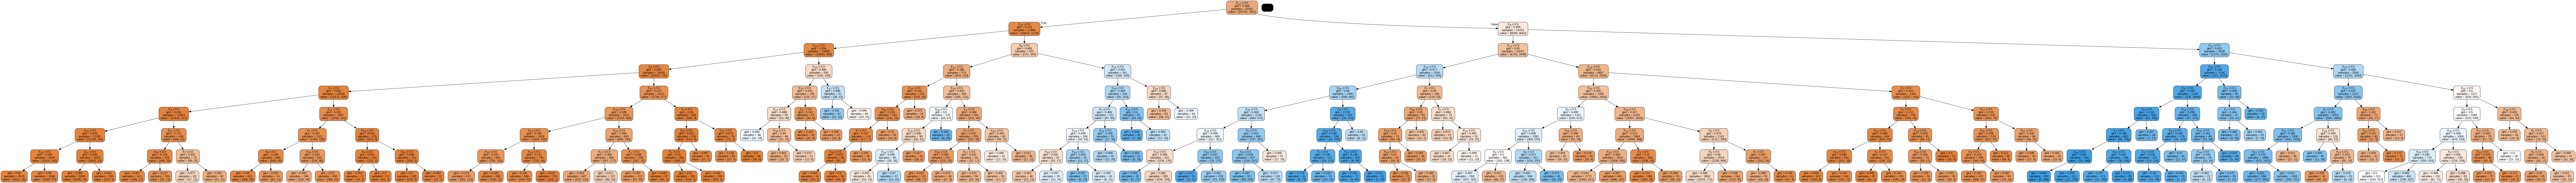

In [47]:
# Graph the decision tree
graph_data = StringIO()
export_graphviz(dtree, out_file= graph_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(graph_data.getvalue())  
Image(graph.create_png())

## Conclusion

Q.4 How long was your total run time to train the best model?


> It took 0.197 seconds to run the code to create the best model and train it with the data.



Q.5 Did you find the BEST TREE?


> I don't know if I found the absolute best tree in terms of accuracy, but I took the combination of the best hyper-parameters based on accuracy scores to create a model.



Q.6 Write your observations from the visualization of the best tree.


> The depth of the tree is only 8, even though we tested depths of up to 20. The tree also seems much more complex than the simple examples we worked with in class. It is somewhat difficult to interpret because it is so large, but with the help of a computer it should be simple to input data and get a result.



Q.7 Will this Tree "overfit" (Hint: Is this tree "fully grown")


> This tree should not overift because it is not fully grown. We were able prune the tree with the hyper-parameters in the last section of the report.



## 8. Prediction Using Your "Trained" Decision Tree Model

In [55]:
prediction_df = pd.DataFrame({"hours_per_week_bin_a. 0-30": 0,	"hours_per_week_bin_b. 31-40": 0,	
                             "hours_per_week_bin_c. 71-100": 0,	"hours_per_week_bin_d. 41-50 &amp; 61-70": 1,	
                             "hours_per_week_bin_e. 51-60": 0,	"occupation_bin_a. Low": 0,
                             "occupation_bin_b. Mid - Low": 1,	"occupation_bin_c. Mid - Mid": 0,
                             "occupation_bin_d. Mid - High": 0,	"occupation_bin_e. High": 0,
                             "msr_bin_a. Low": 0,	"msr_bin_b. Mid": 0,	"msr_bin_c. High": 1,	
                             "capital_gl_bin_a. = 0": 0,	"capital_gl_bin_b. &lt; 0": 0,	"capital_gl_bin_c. &gt; 0": 1,	
                             "race_sex_bin_a. Low":0,	"race_sex_bin_b. Mid":1,
                             "race_sex_bin_c. High":0, "education_num_bin_a. 0-8":0,
                             "education_num_bin_b. 9-12":1, "education_num_bin_c. 13":0, "education_num_bin_d. 14":0,
                             "education_num_bin_e. 15+":0, "education_bin_a. Low":0, "education_bin_b. Mid":0,
                             "education_bin_c. Bachelors":0,"education_bin_d. Masters":0, "education_bin_e. High":1,
                             "workclass_bin_a. no income":0, "workclass_bin_b. income":1, "age_bin_a. 0-25":0,
                             "age_bin_b. 26-30 & 71-100":0, "age_bin_c. 31-35 & 61-70":0, "age_bin_d. 36-40 & 56-60":1,
                             "age_bin_e. 40-55":0}, index = [0])

In [56]:
prediction_df

,hours_per_week_bin_a. 0-30,hours_per_week_bin_b. 31-40,hours_per_week_bin_c. 71-100,hours_per_week_bin_d. 41-50 &amp; 61-70,hours_per_week_bin_e. 51-60,occupation_bin_a. Low,occupation_bin_b. Mid - Low,occupation_bin_c. Mid - Mid,occupation_bin_d. Mid - High,occupation_bin_e. High,...,education_bin_c. Bachelors,education_bin_d. Masters,education_bin_e. High,workclass_bin_a. no income,workclass_bin_b. income,age_bin_a. 0-25,age_bin_b. 26-30 & 71-100,age_bin_c. 31-35 & 61-70,age_bin_d. 36-40 & 56-60,age_bin_e. 40-55
0,0,0,0,1,0,0,1,0,0,0,...,0,0,1,0,1,0,0,0,1,0


In [58]:
new_pred = dtree.predict(prediction_df)
print(new_pred)

[1]


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- capital_gl_bin_b. &lt; 0
- capital_gl_bin_c. &gt; 0
- hours_per_week_bin_d. 41-50 &amp; 61-70
Feature names seen at fit time, yet now missing:
- capital_gl_bin_b. < 0
- capital_gl_bin_c. > 0
- hours_per_week_bin_d. 41-50 & 61-70

  warnings.warn(message, FutureWarning)


Since the output we receieved was a 1, we can say that our decision tree predicted that this individual has a income of greater than 50k. 

Q.8 What is the probability that your prediction for this person is correct?

In [65]:
probability = dtree.predict_proba(prediction_df)
print(probability)

[[0.32894737 0.67105263]]


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- capital_gl_bin_b. &lt; 0
- capital_gl_bin_c. &gt; 0
- hours_per_week_bin_d. 41-50 &amp; 61-70
Feature names seen at fit time, yet now missing:
- capital_gl_bin_b. < 0
- capital_gl_bin_c. > 0
- hours_per_week_bin_d. 41-50 & 61-70

  warnings.warn(message, FutureWarning)


The probability that our prediction score for this person is correct is 67.1%.